<a href="https://colab.research.google.com/github/EnmaSantos/CSE450/blob/main/starter_signs_v2_student_using_advanced_technique_code_chunks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [2]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [4]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Crossroad_Ahead', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'Cars_Prohibited(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Bends_Left_Then_Right', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Uncontrolled_Crossroad', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

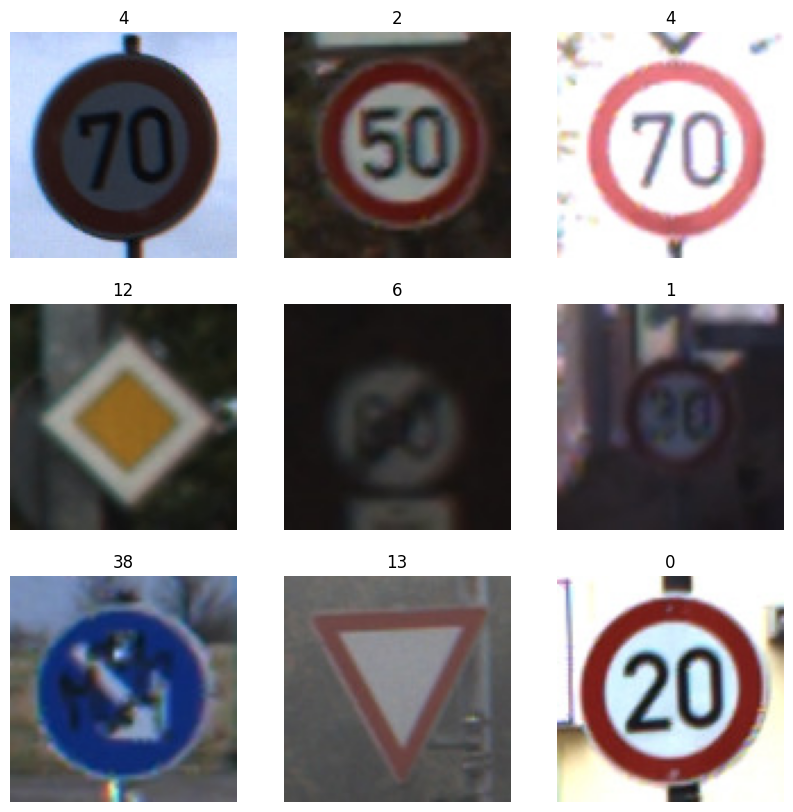

In [5]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [6]:
# Enhanced data augmentation for traffic sign images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,        # Slight rotations (traffic signs should still be upright)
    width_shift_range=0.1,    # Small horizontal shifts
    height_shift_range=0.1,   # Small vertical shifts
    zoom_range=0.1,           # Slight zooming in/out
    brightness_range=(0.8, 1.2),  # Brightness variations
    shear_range=5,            # Slight shearing
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
# We still need basic rescaling for validation data, but no augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


In [8]:
# Update the generators with the new augmentation settings
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="training",
    seed=42
)

validation_generator = validation_datagen.flow_from_directory(
    training_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='sparse',
    subset="validation",
    seed=42
)


Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


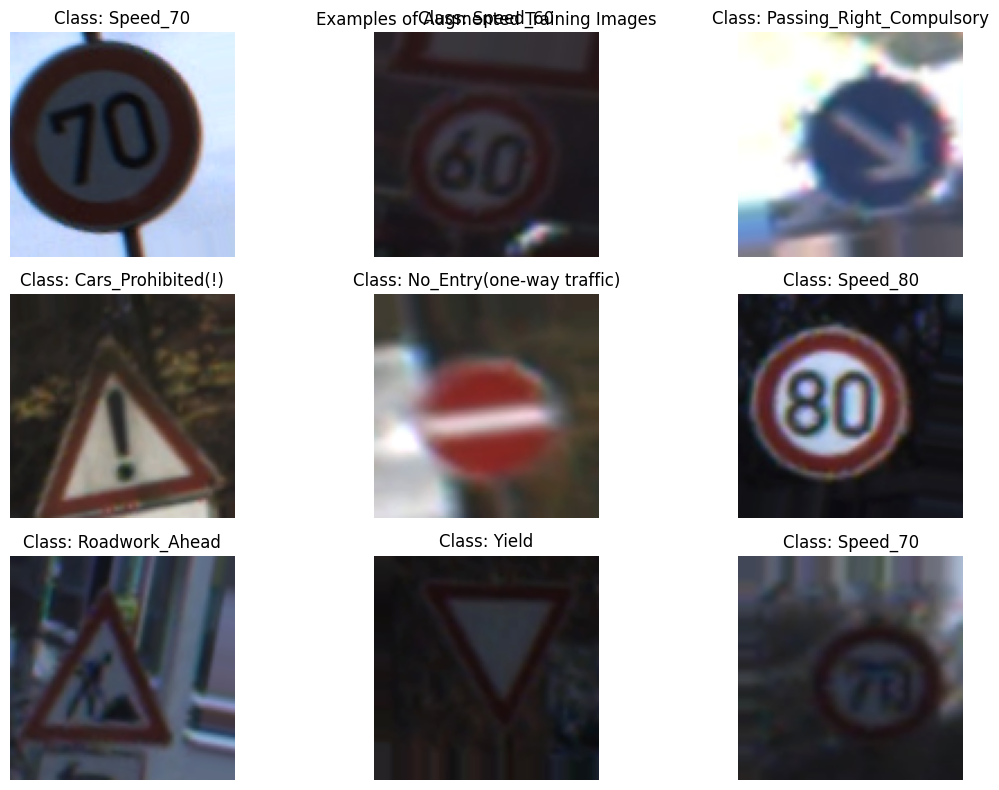

In [9]:
# Visualize some augmented images to verify the augmentation
plt.figure(figsize=(12, 8))
for i in range(9):
    augmented_images, labels = next(train_generator)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0])
    plt.title(f"Class: {target_names[int(labels[0])]}")
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Examples of Augmented Training Images")
plt.show()

In [10]:
# More libraries to further improve the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [11]:
# Define a more advanced CNN architecture
improved_model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(100, 100, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Second convolutional block
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Third convolutional block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')  # 43 classes for German traffic signs
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model with a lower learning rate
improved_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Print model summary
improved_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 25, 25, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,750,603 (37.20 MB)

 Trainable params: 9,748,683 (37.19 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [14]:
# Define callbacks to improve training
callbacks = [
    # Reduce learning rate when validation accuracy plateaus
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Save the best model
    ModelCheckpoint(
        'best_traffic_sign_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
# Train the model with callbacks
history = improved_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  # We'll use early stopping to determine actual epochs
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3794 - loss: 2.4195
Epoch 1: val_accuracy improved from -inf to 0.83650, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 148s 136ms/step - accuracy: 0.3796 - loss: 2.4186 - val_accuracy: 0.8365 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 2/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.8532 - loss: 0.4538
Epoch 2: val_accuracy improved from 0.83650 to 0.93687, saving model to best_traffic_sign_model.h5


981/981 ━━━━━━━━━━━━━━━━━━━━ 121s 124ms/step - accuracy: 0.8532 - loss: 0.4537 - val_accuracy: 0.9369 - val_loss: 0.2297 - learning_rate: 0.0010
Epoch 3/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9430 - loss: 0.1829
Epoch 3: val_accuracy did not improve from 0.93687
981/981 ━━━━━━━━━━━━━━━━━━━━ 142s 124ms/step - accuracy: 0.9430 - loss: 0.1829 - val_accuracy: 0.9361 - val_loss: 0.2087 - learning_rate: 0.0010
Epoch 4/50
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9652 - loss: 0.1122
Epoch 4: val_accuracy did not improve from 0.93687
981/981 ━━━━━━━━━━━━━━━━━━━━ 119s 122ms/step - accuracy: 0.9652 - loss: 0.1122 - val_accuracy: 0.9202 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 5/50
619/981 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - accuracy: 0.9609 - loss: 0.1302

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

In [ ]:
# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

In [ ]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# This is an optional advanced addition to help understand what the model is learning
from tensorflow.keras.models import Model
import cv2
import numpy as np

# Function to create a heatmap of what the CNN is focusing on
def generate_cam(model, img_array, class_idx, layer_name='conv2d_5'):
    # Create a model that will output the last conv layer
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    # Convert image to array and perform the same preprocessing
    img_array = np.expand_dims(img_array, axis=0)

    # Compute gradient of the predicted class with respect to feature map activations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, class_idx]

    # Gradient of the class output with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)

    # Vector of mean gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight feature maps by gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Resize heatmap to original image size
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))

    # Convert to RGB for overlay
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on original image
    superimposed_img = heatmap * 0.4 + img_array[0] * 255
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    return superimposed_img

In [ ]:
# Additional imports for evaluation metrics
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
# Step 1: Load the mini holdout dataset
mini_holdout_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
mini_holdout_generator = test_datagen.flow_from_directory(
        mini_holdout_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode=None,
        shuffle=False,
        batch_size=1)

In [ ]:
# Step 2: Get the filenames from the generator
filenames = mini_holdout_generator.filenames
base_filenames = [os.path.basename(filename) for filename in filenames]
print(f"Number of images in mini_holdout: {len(base_filenames)}")

In [ ]:
# Step 3: Load ground truth labels from the CSV file
ground_truth_df = pd.read_csv('/content/mini_holdout_answers.csv')
print("First few rows of the ground truth data:")
print(ground_truth_df.head())
print(f"Number of entries in CSV: {len(ground_truth_df)}")

In [ ]:
# Step 4: Generate predictions with our trained model
# FIXED: Changed 'model' to 'improved_model'
mini_holdout_generator.reset()
mini_holdout_probabilities = improved_model.predict(mini_holdout_generator)
mini_holdout_predictions = [np.argmax(probas) for probas in mini_holdout_probabilities]

In [ ]:
# Step 5: Create a DataFrame with predictions and filenames
predictions_df = pd.DataFrame({
    'Filename': base_filenames,
    'Predicted_ClassId': mini_holdout_predictions
})

In [ ]:
# Step 6: Merge with ground truth to ensure proper alignment
evaluation_df = pd.merge(ground_truth_df, predictions_df, on='Filename', how='inner')
print(f"Number of matched predictions: {len(evaluation_df)}")

In [ ]:
# Step 7: Calculate accuracy
accuracy = accuracy_score(evaluation_df['ClassId'], evaluation_df['Predicted_ClassId'])
print(f"\nModel Accuracy on Mini Holdout Set: {accuracy:.4f} ({accuracy*100:.2f}%)")

In [ ]:
# Step 8: Find the unique classes in the ground truth data
unique_classes = sorted(evaluation_df['ClassId'].unique())
print(f"\nNumber of unique classes in mini holdout: {len(unique_classes)}")
print(f"Classes present: {unique_classes}")

In [ ]:
# Create a mapping from class ID to index position for the classification report
present_target_names = [target_names[i] for i in unique_classes]

In [ ]:
# Step 9: Generate detailed classification metrics with only the present classes
print("\nClassification Report:")
class_report = classification_report(
    evaluation_df['ClassId'],
    evaluation_df['Predicted_ClassId'],
    labels=unique_classes,  # Use only the classes that are present
    target_names=present_target_names,
    zero_division=0
)
print(class_report)

In [ ]:
# Step 10: Create and visualize confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(
    evaluation_df['ClassId'],
    evaluation_df['Predicted_ClassId'],
    labels=unique_classes  # Use only the classes that are present
)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Mini Holdout Dataset')
plt.tight_layout()
plt.show()


In [ ]:
# Step 11: Visualize examples of correct and incorrect predictions
plt.figure(figsize=(20, 16))
count_correct = 0
count_incorrect = 0
examples_to_show = 5

In [ ]:
# Create image mapping for easier lookup
mini_holdout_generator.reset()
image_dict = {}
for i, image in enumerate(mini_holdout_generator):
    if i >= len(base_filenames):
        break
    image_dict[base_filenames[i]] = image[0]

In [ ]:
# Find examples of correct and incorrect predictions
for _, row in evaluation_df.iterrows():
    is_correct = row['ClassId'] == row['Predicted_ClassId']

    if ((is_correct and count_correct < examples_to_show) or
        (not is_correct and count_incorrect < examples_to_show)):

        image = image_dict.get(row['Filename'])
        if image is None:
            continue

        if is_correct:
            position = count_correct + 1
            count_correct += 1
            title_color = 'green'
        else:
            position = examples_to_show + count_incorrect + 1
            count_incorrect += 1
            title_color = 'red'

        plt.subplot(2, examples_to_show, position)
        plt.imshow((image * 255).astype("uint8"))
        true_name = target_names[row['ClassId']]
        pred_name = target_names[row['Predicted_ClassId']]
        plt.title(f"True: {true_name}\nPred: {pred_name}", color=title_color)
        plt.axis('off')
        # Stop when we have enough examples of each
    if count_correct >= examples_to_show and count_incorrect >= examples_to_show:
        break

In [ ]:

plt.suptitle("Examples of Correct (top) and Incorrect (bottom) Predictions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Step 12: Analyze which sign types have the highest error rates
evaluation_df['is_correct'] = evaluation_df['ClassId'] == evaluation_df['Predicted_ClassId']
error_df = evaluation_df[~evaluation_df['is_correct']]

In [ ]:
if len(error_df) > 0:
    # Map class IDs to their names
    error_df['true_sign_name'] = error_df['ClassId'].map(lambda x: target_names[x])

    # Count errors by sign type
    error_counts = error_df['true_sign_name'].value_counts()

    print("\nSign types with the highest error counts:")
    print(error_counts.head(10))

    # Create a bar chart of the most frequently misclassified signs
    plt.figure(figsize=(12, 6))
    error_counts.head(min(10, len(error_counts))).plot(kind='bar')
    plt.title('Sign Types with Highest Error Counts')
    plt.xlabel('Sign Type')
    plt.ylabel('Error Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
 # Step 13: Also analyze confusion patterns
    if len(error_df) > 5:  # Only if we have enough errors to analyze
        error_df['pred_sign_name'] = error_df['Predicted_ClassId'].map(lambda x: target_names[x])
        confusion_pairs = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
        confusion_pairs = confusion_pairs.sort_values(ascending=False)

        print("\nMost common confusion patterns:")
        print(confusion_pairs.head(min(10, len(confusion_pairs))))
        print("\nThese patterns indicate which signs are most frequently confused with each other.")

In [ ]:
# This code should be added after running the model and generating predictions

# Create a detailed visualization of incorrectly classified images
def visualize_errors(evaluation_df, image_dict, target_names, max_examples=20):
    """
    Creates a detailed visualization of incorrectly classified images

    Parameters:
    evaluation_df - DataFrame with true and predicted classes
    image_dict - Dictionary mapping filenames to image data
    target_names - List of class names
    max_examples - Maximum number of examples to display
    """
    # Filter for incorrect predictions only
    error_df = evaluation_df[evaluation_df['ClassId'] != evaluation_df['Predicted_ClassId']].copy()

    # Get the number of errors to display (up to max_examples)
    num_errors = min(len(error_df), max_examples)

    if num_errors == 0:
        print("No errors found! The model correctly classified all images.")
        return

    # Calculate grid dimensions
    cols = 4  # 4 images per row
    rows = (num_errors + cols - 1) // cols  # Ceiling division

    # Create a larger figure to accommodate more images
    plt.figure(figsize=(20, 5 * rows))

    # Add each incorrect prediction to the plot
    for i, (_, row) in enumerate(error_df.head(num_errors).iterrows()):
        if i >= max_examples:
            break

        # Get the image
        image = image_dict.get(row['Filename'])
        if image is None:
            continue

        # Create subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow((image * 255).astype("uint8"))

        # Get true and predicted class names
        true_name = target_names[row['ClassId']]
        pred_name = target_names[row['Predicted_ClassId']]

        # Display detailed information
        plt.title(f"True: {true_name}\nPred: {pred_name}", color='red')
        plt.xlabel(f"Filename: {row['Filename']}")
        plt.axis('off')

    plt.suptitle(f"Incorrectly Classified Images (showing {num_errors} out of {len(error_df)} errors)",
                fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Additionally, group errors by true class for analysis
    print("\nErrors grouped by true sign type:")
    error_class_counts = error_df.groupby('ClassId').size()
    for class_id, count in error_class_counts.items():
        print(f"{target_names[class_id]}: {count} errors")

    # Show confusion patterns (what signs get confused with what)
    print("\nDetailed confusion patterns:")
    error_df['true_sign_name'] = [target_names[x] for x in error_df['ClassId']]
    error_df['pred_sign_name'] = [target_names[x] for x in error_df['Predicted_ClassId']]

    confusion_patterns = error_df.groupby(['true_sign_name', 'pred_sign_name']).size()
    for (true_name, pred_name), count in confusion_patterns.items():
        print(f"{true_name} mistaken as {pred_name}: {count} times")

# Call this function to visualize errors
visualize_errors(evaluation_df, image_dict, target_names, max_examples=20)